In [21]:
import os
import cv2 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from sklearn.cluster import KMeans
from skimage.morphology import erosion, opening, square, \
                               disk, convex_hull_image
from skimage.measure import label
    
SMALL_FONT = 13
MEDIUM_FONT = 15
LARGE_FONT = 18

plt.rc('font', size=SMALL_FONT)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_FONT)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_FONT)    # legend fontsize
plt.rc('figure', titlesize=LARGE_FONT)  # fontsize of the figure title

plt.rcParams["figure.figsize"] = (10, 5)

In [2]:
def readSortedSlices(path):
    
    slices = []
    for s in os.listdir(path):
        slices.append(path + '/' + s)
        
    slices.sort(key = lambda s: int(s[s.find('_') + 1 : s.find('.')]))

    ID = slices[0][slices[0].find('/') + 1 : slices[0].find('_')]
    print('CT scan of Patient %s consists of %d slices.' % (ID, len(slices)))  
    return (slices, ID)

def readImg(path):
    img = cv2.imread(path)
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def getSliceImages(slices):
    
    return list(map(readImg, slices))

In [3]:
slices, PatientID = readSortedSlices('sample-dataset')
sliceImgs = getSliceImages(slices)

CT scan of Patient ID00007637202177411956430 consists of 30 slices.


Image Dimensions: (512, 512)


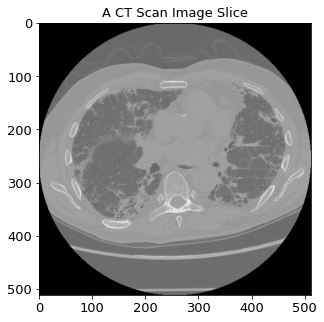

In [23]:
# Select a sample slice to work with
im = readImg('sample-dataset/ID00007637202177411956430_16.jpg')
plt.title('A CT Scan Image Slice')
plt.imshow(im, cmap='gray')
print('Image Dimensions:', im.shape)

# Preprocessing the CT Image

In [18]:
# TODO: Implement histogram plotting
def imgKMeans(img, K, showOutput=0, showHistogram=0):
    '''
    Apply KMeans on an image with the number of clusters K
    Input: Image, Number of clusters K
    Output: Dictionary of cluster center labels and points, Output segmented image
    '''
    imgflat = np.reshape(img, img.shape[0] * img.shape[1]).reshape(-1, 1)
        
    kmeans = KMeans(n_clusters=K, verbose=0)
    
    kmmodel = kmeans.fit(imgflat)
    
    labels = kmmodel.labels_
    centers = kmmodel.cluster_centers_
    center_labels = dict(zip(np.arange(K), centers))
    
    output = np.array([center_labels[label] for label in labels])
    output = output.reshape(img.shape[0], img.shape[1]).astype(int)
    
    print(len(labels), 'Labels: \n', labels)
    print(len(centers), 'Centers: \n', centers)
    print('Center labels and their points:', center_labels)
    
    if showOutput:

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes = axes.ravel()

        axes[0].imshow(img, cmap='gray')
        axes[0].set_title('Original Image')

        axes[1].imshow(output)
        axes[1].set_title('Image after KMeans (K = ' + str(K) + ')')
    
    return center_labels, output

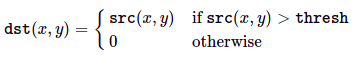

262144 Labels: 
 [1 1 1 ... 1 1 1]
3 Centers: 
 [[1.57879115e+02]
 [8.82521695e-02]
 [1.12269714e+02]]
Center labels and their points: {0: array([157.87911491]), 1: array([0.08825217]), 2: array([112.26971435])}


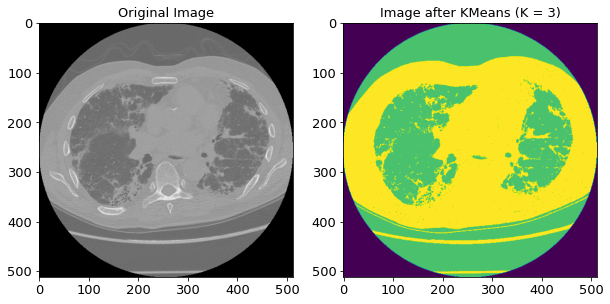

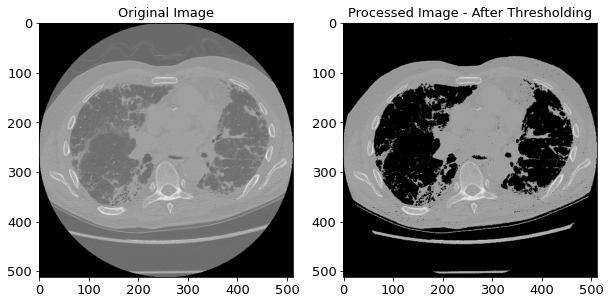

In [27]:
def preprocessImage(img, showOutput=0):
    '''
    Preprocess the image by applying truncated thresholding using KMeans
    Input: Image
    Output: Preprocessed Ima
    '''
    centroids, segmented_img = imgKMeans(im, 3, showOutput=1)
    
    sorted_center_values = sorted([i[0] for i in centroids.values()])
    threshold = (sorted_center_values[-1] + sorted_center_values[-2]) / 2
    
    retval, procImg = cv2.threshold(im, threshold, 255, cv2.THRESH_TOZERO) 
    
    if showOutput:
        
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes = axes.ravel()

        axes[0].imshow(img, cmap='gray')
        axes[0].set_title('Original Image')

        axes[1].imshow(procImg, cmap='gray')
        axes[1].set_title('Processed Image - After Thresholding')
    
    return procImg

preprocessImage(im, showOutput=1)

In [10]:
def chullForegroundMask(img):
    '''
    Generate a convex hull of foreground mask
    Input: Whole chest CT image in grayscale format (512x512)
    Output: Convex hull of foreground mask in binary format (512x512)
    '''
    
    centroid_clusters, segmented_img = imgKMeans(img, 2, showOutput=1)
    
    fg_threshold = sum(centroid_clusters.values())[0] / 2
    
    if img > fg_threshold:
        fg_mask = 1
    else:
        fg_mask = 0
    
    plt.imshow(fg_mask)